In [22]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from datetime import datetime

In [3]:
# Ticker symbol for S&P 500 index
ticker_symbol = '^GSPC'

# Fetch historical data
sp500_data = yf.download(ticker_symbol, start='1900-01-01', end='2023-12-31')

# Display the fetched data
print(sp500_data)

[*********************100%%**********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
1927-12-30    17.660000    17.660000    17.660000    17.660000    17.660000   
1928-01-03    17.760000    17.760000    17.760000    17.760000    17.760000   
1928-01-04    17.719999    17.719999    17.719999    17.719999    17.719999   
1928-01-05    17.549999    17.549999    17.549999    17.549999    17.549999   
1928-01-06    17.660000    17.660000    17.660000    17.660000    17.660000   
...                 ...          ...          ...          ...          ...   
2023-12-13  4646.200195  4709.689941  4643.229980  4707.089844  4707.089844   
2023-12-14  4721.040039  4738.569824  4694.339844  4719.549805  4719.549805   
2023-12-15  4714.229980  4725.529785  4704.689941  4719.189941  4719.189941   
2023-12-18  4725.580078  4749.520020  4725.580078  4740.560059

In [4]:
#LOG RELATIVE - currently not used
log_today = np.log(sp500_data['Close'])
log_yesterday =np.log(sp500_data['Close'].shift(1))
sqrt_252 = np.sqrt(252)
log_data = (log_today/log_yesterday)*sqrt_252
log_data

Date
1927-12-30          NaN
1928-01-03    15.905726
1928-01-04    15.862066
1928-01-05    15.821274
1928-01-06    15.909128
                ...    
2023-12-13    15.899999
2023-12-14    15.879470
2023-12-15    15.874365
2023-12-18    15.882986
2023-12-19    15.881647
Name: Close, Length: 24108, dtype: float64

Text(0.5, 1.0, 'Log Relative for SP500')

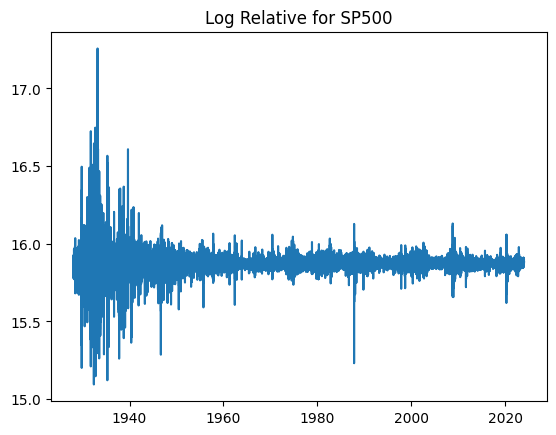

In [5]:
plt.plot(log_data)
plt.title('Log Relative for SP500')

[*********************100%%**********************]  1 of 1 completed
                   Open         High          Low        Close  \
Date                                                             
1983-01-03   140.649994   141.330002   138.199997   138.339996   
1983-01-04   138.330002   141.360001   138.080002   141.360001   
1983-01-05   141.350006   142.600006   141.149994   141.960007   
1983-01-06   142.009995   145.770004   142.009995   145.270004   
1983-01-07   145.270004   146.460007   145.149994   145.179993   
...                 ...          ...          ...          ...   
2023-12-13  4646.200195  4709.689941  4643.229980  4707.089844   
2023-12-14  4721.040039  4738.569824  4694.339844  4719.549805   
2023-12-15  4714.229980  4725.529785  4704.689941  4719.189941   
2023-12-18  4725.580078  4749.520020  4725.580078  4740.560059   
2023-12-19  4743.720215  4764.189941  4743.720215  4758.620117   

            Garman_Klass_Estimator  
Date                               

Text(0.5, 1.0, 'Garman_Klass_Estimator')

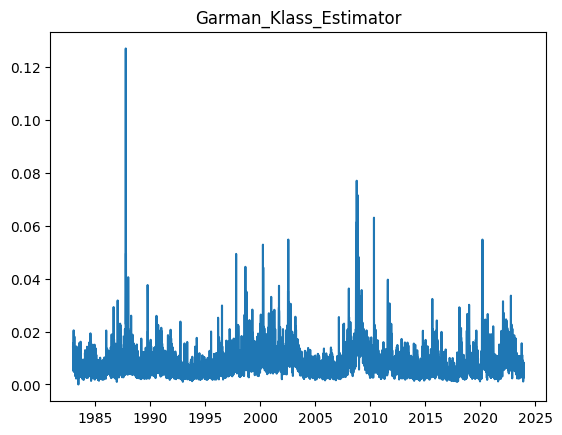

In [6]:
#CALCULATE GARMAN KLASS FOR EACH DAY

# Download S&P 500 data from Yahoo Finance
sp500 = yf.download('^GSPC', start='1983-01-01', end='2023-12-31')

# Calculate Garman-Klass estimator for each day
def calculate_gk_estimator(high, low, open_price, close):
    log_hl = np.log(high / low)
    log_co = np.log(close / open_price)
    log_co_square = log_co ** 2
    return np.sqrt((1 / (2)) * np.sum(log_hl ** 2 - (2 * np.log(2) - 1) * log_co_square))

# Create an empty list to store daily estimators
gk_estimators = []

# Iterate through the dataset day by day
for i in range(len(sp500)):
    high = sp500['High'].iloc[i]
    low = sp500['Low'].iloc[i]
    open_price = sp500['Open'].iloc[i]
    close = sp500['Close'].iloc[i]

    # Calculate the Garman-Klass estimator for the current day
    gk_est = calculate_gk_estimator(high, low, open_price, close)
    gk_estimators.append(gk_est)

# Add the daily estimators to the DataFrame
sp500['Garman_Klass_Estimator'] = gk_estimators

# Displaying the DataFrame with the Garman-Klass estimator for each day
print(sp500[['Open', 'High', 'Low', 'Close', 'Garman_Klass_Estimator']])
plt.plot(sp500['Garman_Klass_Estimator'])
plt.title('Garman_Klass_Estimator')

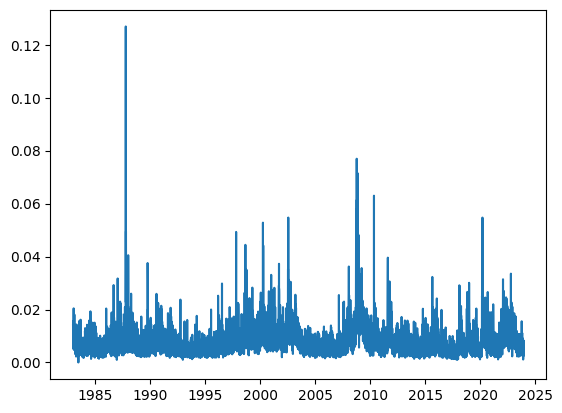

In [28]:
#ADD TRADING_DAY COLUMN
# Add a column labeling each trading day from 1 to 252
sp500['Year'] = sp500.index.year

# Calculate the total number of trading days in each year
total_trading_days = sp500.groupby('Year').size()

# Add a column labeling each trading day from 1 to 252 and divide by the total trading days in that year
sp500['Trading_Day'] = sp500.groupby('Year').cumcount() + 1

# Get today's date
current_date = datetime.now()

# Define the start and end dates for the current year
start_date = pd.Timestamp(datetime(current_date.year, 1, 1))  # January 1st of the current year
end_date = pd.Timestamp(datetime(current_date.year, 12, 31))  # December 31st of the current year

# Generate a date range from today until the end of the year (excluding weekends and holidays)
date_range = pd.date_range(start=current_date, end=end_date, freq=BDay())

# Calculate the remaining trading days in the year
remaining_trading_days = len(date_range)

# Create a function to divide Trading_Day by the total trading days of its year
def calculate_trading_day_ratio(row):
    year = row['Year']
    if year < current_date.year:
        return row['Trading_Day'] / total_trading_days[year]
    else: 
        return row['Trading_Day'] / (total_trading_days[year]+remaining_trading_days)

# Apply the function to create Trading_Day_Ratio column
sp500['Trading_Day_Ratio'] = sp500.apply(calculate_trading_day_ratio, axis=1)


There are 8 trading days remaining in the year.


In [15]:
#ADD QUARTER END COLUMN
sp500['Quarter_End'] = sp500.index - pd.offsets.BQuarterEnd()
#quarter_ends = sp500.groupby(sp500['Quarter_End'].dt.to_period('Q'))['Date'].max()

# Calculate the difference between 'Date' and 'Quarter_End' in days
sp500['Days_After_Quarter_End'] = (sp500.index - sp500['Quarter_End']).dt.days

# Create 'Seasonal_Trading' column based on the condition (25-31 days after Quarter End)
sp500['Seasonal_Trading'] = 0  # Initialize with 0
sp500.loc[(sp500['Days_After_Quarter_End'] >= 25) & (sp500['Days_After_Quarter_End'] <= 31), 'Seasonal_Trading'] = 1



,Open,High,Low,Close,Adj Close,Volume,Garman_Klass_Estimator,Year,Trading_Day,Quarter_End,Days_After_Quarter_End,Seasonal_Trading
Date,,,,,,,,,,,,
1983-01-25,139.979996,141.750000,139.979996,141.750000,141.750000,79740000,0.006961,1983,17,1982-12-31,25,1
1983-01-26,141.770004,142.160004,141.160004,141.539993,141.539993,73720000,0.004940,1983,18,1982-12-31,26,1
1983-01-27,141.539993,144.300003,141.539993,144.270004,144.270004,88120000,0.010770,1983,19,1982-12-31,27,1
1983-01-28,144.309998,145.470001,144.250000,144.509995,144.509995,89490000,0.005924,1983,20,1982-12-31,28,1
1983-01-31,144.509995,145.300003,143.929993,145.300003,145.300003,67140000,0.006256,1983,21,1982-12-31,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,4235.790039,4259.379883,4219.430176,4247.680176,4247.680176,3821820000,0.006549,2023,204,2023-09-29,25,1
2023-10-25,4232.419922,4232.419922,4181.419922,4186.770020,4186.770020,3869370000,0.007125,2023,205,2023-09-29,26,1
2023-10-26,4175.990234,4183.600098,4127.899902,4137.229980,4137.229980,4277640000,0.008546,2023,206,2023-09-29,27,1


In [16]:
#HAR MODEL
import statsmodels.api as sm

# Calculating different volatility measures
sp500['yesterday_volatility'] = sp500['Garman_Klass_Estimator'].shift(1)
sp500['avg_2_5_day_volatility'] = sp500['Garman_Klass_Estimator'].shift(6).rolling(window=5).mean()
sp500['avg_6_21_day_volatility'] = sp500['Garman_Klass_Estimator'].shift(21).rolling(window=16).mean()

# Dropping NaN values resulting from rolling means
data = sp500.dropna()

# Creating the HAR model
X = data[['yesterday_volatility', 'avg_2_5_day_volatility', 'avg_6_21_day_volatility', 'Trading_Day', 'Seasonal_Trading']]
X = sm.add_constant(X)  # Adding a constant coefficient
y = data['Garman_Klass_Estimator']

# Fitting the model
model = sm.OLS(y, X).fit()

# Printing the model summary
print(model.summary())


                              OLS Regression Results                              
Dep. Variable:     Garman_Klass_Estimator   R-squared:                       0.492
Model:                                OLS   Adj. R-squared:                  0.491
Method:                     Least Squares   F-statistic:                     1990.
Date:                    Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                            12:46:20   Log-Likelihood:                 41930.
No. Observations:                   10291   AIC:                        -8.385e+04
Df Residuals:                       10285   BIC:                        -8.381e+04
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------